In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Data Files
from panel import state

# csv path
state_data = "./usa_county_wise.csv"

#create dataframe
state_data_df = pd.read_csv(state_data)
state_data_df

state_data_df["Date"].max()

'7/9/20'

In [3]:
# Filtering the data based on the last date
state_data_df = state_data_df.loc[state_data_df["Date"] == state_data_df["Date"].max(),:]

In [4]:
# drop unwanted columns
state_clean_df = state_data_df.drop(["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Country_Region", "Lat", "Long_", "Combined_Key", "Date"], axis = 1)

# state_data_df["Province_State"].unique() - Used to find list of states

#states list for isin function
states = ['Alabama', 'Alaska', 'Arizona',
       'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming']

state_clean_df = state_clean_df[state_clean_df["Province_State"].isin(states)]

#print the dataframe
state_clean_df

# state_clean_df["Province_State"].unique() - Used to test states list filter works

,Province_State,Confirmed,Deaths
564542,Alabama,653,13
564543,Alabama,1114,10
564544,Alabama,367,2
564545,Alabama,208,1
564546,Alabama,273,1
...,...,...,...
567795,Utah,243,0
567796,Utah,47,0
567797,Utah,1881,15
567798,Utah,63,0


In [5]:
# group the statistics by the sum of cases and deaths by state
state_clean2_df = state_clean_df.groupby(by = ["Province_State"]).sum()
state_clean2_df

,Confirmed,Deaths
Province_State,,
Alabama,49174,1043
Alaska,1268,46
Arizona,112671,2063
Arkansas,26052,311
California,302484,6860
Colorado,35507,1706
Connecticut,47209,4348
Delaware,12531,508
Florida,232718,4018


# Code added by Cheila

## Getting data from Census API

* Check the population for each state via Census API call
* Calculate Deaths per capita
* Calculate Cases per capita
* % Change in GDP

In [6]:
#### Code added by Cheila

# Importing dependencies
import requests
from census import Census

# Census & Gmaps API Keys
from api_keys import (census_api_key, g_key)
c = Census(census_api_key, year=2020)

census_data = c.acs5.get(("NAME", "B01003_001E", "B19301_001E"), {'for': 'state:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Renaming and Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Province_State",
                                      "state": "State"})

census_pd = census_pd[["Province_State", "Population", "Per Capita Income"]]

# Merging the Statistic DataFrame and Census DataFrame
merged_df = pd.merge(state_clean2_df, census_pd, on="Province_State", how="left")

# Calculating "Deaths Per Capita" and "Cases Per Capita"
merged_df["Deaths Per Capita (%)"] = (merged_df["Deaths"] / merged_df["Population"]) * 100
merged_df["Cases Per Capita (%)"] = (merged_df["Confirmed"] / merged_df["Population"]) * 100
merged_df["Deaths per Confirmed Cases (%)"] = (merged_df["Deaths"] / merged_df["Confirmed"]) * 100

merged_df.head()

,Province_State,Confirmed,Deaths,Population,Per Capita Income,Deaths Per Capita (%),Cases Per Capita (%),Deaths per Confirmed Cases (%)
0,Alabama,49174,1043,4893186.0,28934.0,0.021315,1.004949,2.121040
1,Alaska,1268,46,736990.0,37094.0,0.006242,0.172051,3.627760
2,Arizona,112671,2063,7174064.0,32340.0,0.028756,1.570532,1.830995
3,Arkansas,26052,311,3011873.0,27724.0,0.010326,0.864977,1.193766
4,California,302484,6860,39346023.0,38576.0,0.017435,0.768779,2.267889


## Generating the Plot

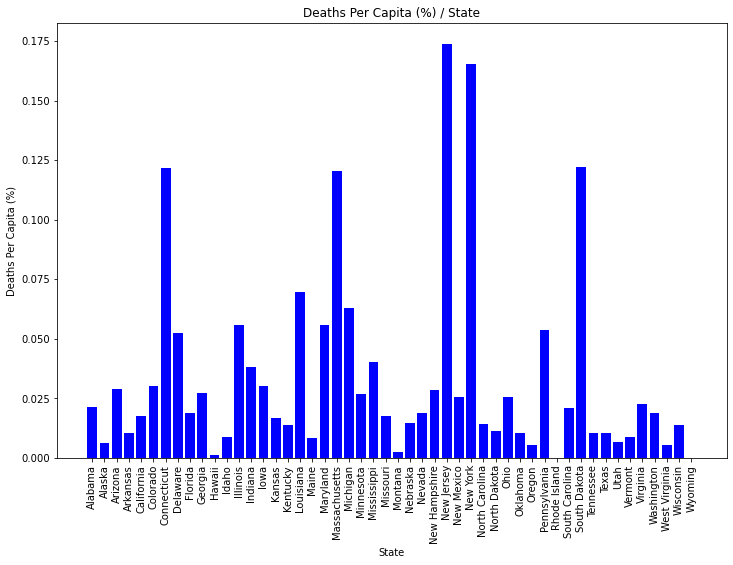

In [7]:
plt.figure(figsize=(12,8))

# Creating the plot using Matplotlib's pyplot methods
plt.bar(x=merged_df["Province_State"], height=merged_df["Deaths Per Capita (%)"], color="b")
plt.title("Deaths Per Capita (%) / State")
plt.xlabel("State")
plt.ylabel("Deaths Per Capita (%)")
plt.xticks(rotation="vertical")
plt.show()

# Analysis
* This plot brings the impact and % of deths per capita for each State.
* As an example, in New Jersey, 175 deaths for each 10,000 people.
* More than 100 deths per group of 10k people in Connecticut, Massachusetts, New Jersey, New York and South Dakota

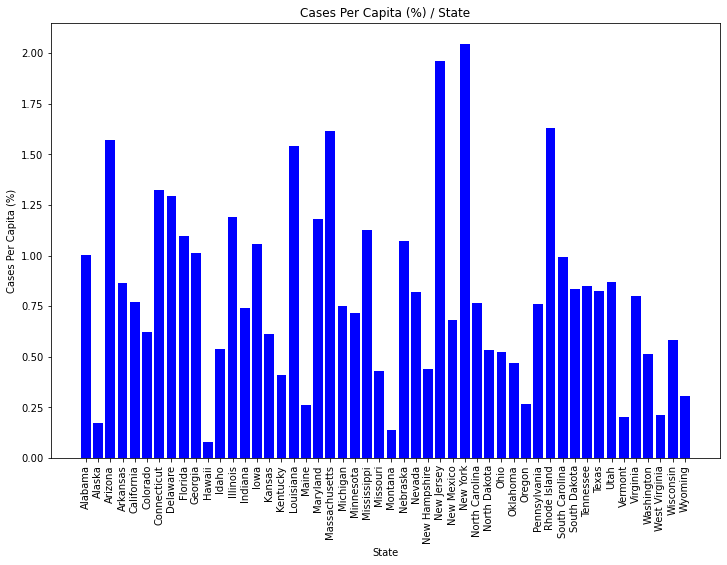

In [8]:
plt.figure(figsize=(12,8))

# Creating the plot using Matplotlib's pyplot methods
plt.bar(x=merged_df["Province_State"], height=merged_df["Cases Per Capita (%)"], color="b")
plt.title("Cases Per Capita (%) / State")
plt.xlabel("State")
plt.ylabel("Cases Per Capita (%)")
plt.xticks(rotation="vertical")
plt.show()

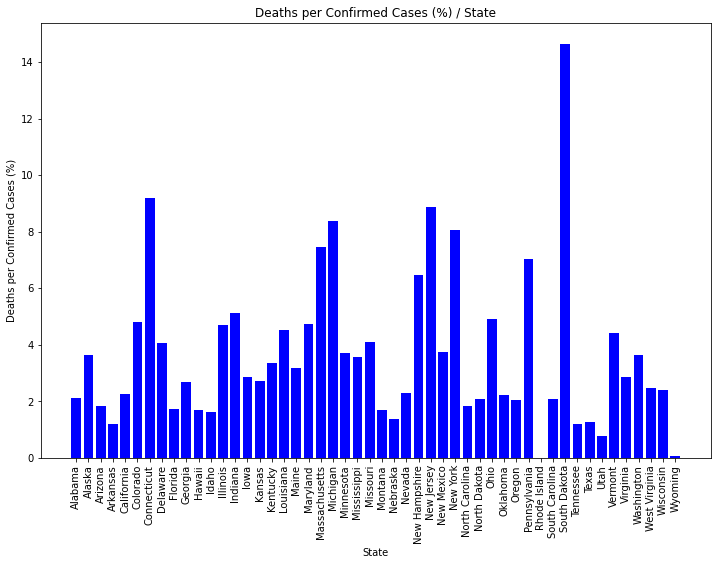

In [9]:
plt.figure(figsize=(12,8))

# Creating the plot using Matplotlib's pyplot methods
plt.bar(x=merged_df["Province_State"], height=merged_df["Deaths per Confirmed Cases (%)"], color="b")
plt.title("Deaths per Confirmed Cases (%) / State")
plt.xlabel("State")
plt.ylabel("Deaths per Confirmed Cases (%)")
plt.xticks(rotation="vertical")
plt.show()

In [10]:
# reading the csv data vaccination file

#create dataframe
vaccination_data_master_df = pd.read_csv("./usa_covid-vaccination_2020.csv")



    
##vaccination_clean_df = vaccination_data_df[["RegionName", "Date", "Confirmed", "Deaths"]]      
#vaccination_clean_df.head()

##state_data_df["Date"].max()


C:\Users\giova\AppData\Local\Temp\ipykernel_9968\1380977092.py:4: DtypeWarning: Columns (82,93,121,122,130) have mixed types. Specify dtype option on import or set low_memory=False.
  vaccination_data_master_df = pd.read_csv("./usa_covid-vaccination_2020.csv")


In [11]:
vaccination_clean_df = vaccination_data_master_df.copy()

# Filtering the data based on the last date, 
vaccination_clean_df = vaccination_clean_df.loc[vaccination_clean_df["Date"] == vaccination_clean_df["Date"].max(),:]
vaccination_clean_df = vaccination_clean_df.loc[vaccination_clean_df["RegionName"] != "Washington DC",:]
vaccination_clean_df = vaccination_clean_df.dropna(subset=["RegionName"])

#Create a datafreame only RegionName", "Date", "ConfirmedCases", "ConfirmedDeaths", "StringencyIndex_Vaccinated", "GovernmentResponseIndex_Vaccinated_ForDisplay"

vaccination_clean_df = vaccination_clean_df[["RegionName", "Date", "ConfirmedCases", "ConfirmedDeaths", "StringencyIndex_Vaccinated", "GovernmentResponseIndex_Vaccinated_ForDisplay"]] 


##vaccination_clean4_df = vaccination_clean_df.groupby(by = ["RegionName"]).sum()

vaccination_clean_df

,RegionName,Date,ConfirmedCases,ConfirmedDeaths,StringencyIndex_Vaccinated,GovernmentResponseIndex_Vaccinated_ForDisplay
731,Alaska,20201231,47014.0,206.0,65.28,61.35
1097,Alabama,20201231,361226.0,4827.0,43.52,49.90
1463,Arkansas,20201231,225138.0,3676.0,50.93,58.75
1829,Arizona,20201231,520207.0,8864.0,57.41,57.55
2195,California,20201231,2384691.0,25848.0,66.20,69.95
2561,Colorado,20201231,361021.0,5420.0,56.02,61.09
2927,Connecticut,20201231,185708.0,5995.0,67.59,71.25
3659,Delaware,20201231,57456.0,1061.0,63.89,68.96
4025,Florida,20201231,1323315.0,21673.0,47.69,53.02
4391,Georgia,20201231,666452.0,10934.0,54.63,57.45


In [14]:
# Calculating "Deaths Per Capita" and "Cases Per Capita"
vaccination_clean_df["Deaths Per Vaccination"] = (vaccination_clean_df["ConfirmedDeaths"] / vaccination_clean_df["StringencyIndex_Vaccinated"])
vaccination_clean_df["Confirmed cases Per Vaccination)"] = (vaccination_clean_df["ConfirmedCases"] / vaccination_clean_df["StringencyIndex_Vaccinated"])
vaccination_clean_df

,RegionName,Date,ConfirmedCases,ConfirmedDeaths,StringencyIndex_Vaccinated,GovernmentResponseIndex_Vaccinated_ForDisplay,Deaths Per Vaccination,Confirmed cases Per Vaccination)
731,Alaska,20201231,47014.0,206.0,65.28,61.35,3.155637,720.189951
1097,Alabama,20201231,361226.0,4827.0,43.52,49.90,110.914522,8300.229779
1463,Arkansas,20201231,225138.0,3676.0,50.93,58.75,72.177499,4420.537993
1829,Arizona,20201231,520207.0,8864.0,57.41,57.55,154.398188,9061.261104
2195,California,20201231,2384691.0,25848.0,66.20,69.95,390.453172,36022.522659
2561,Colorado,20201231,361021.0,5420.0,56.02,61.09,96.751160,6444.501964
2927,Connecticut,20201231,185708.0,5995.0,67.59,71.25,88.696553,2747.566208
3659,Delaware,20201231,57456.0,1061.0,63.89,68.96,16.606668,899.295664
4025,Florida,20201231,1323315.0,21673.0,47.69,53.02,454.455861,27748.270078
4391,Georgia,20201231,666452.0,10934.0,54.63,57.45,200.146440,12199.377631


In [ ]:
len(vaccination_clean_df)